In [1]:
import os
import datetime

import IPython
import IPython.display

from confluent_kafka import avro, Consumer, KafkaError, KafkaException
from confluent_kafka.avro import CachedSchemaRegistryClient
from confluent_kafka.avro.serializer.message_serializer import MessageSerializer as AvroSerde

import json
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [2]:
schema_registry = CachedSchemaRegistryClient(os.getenv("SCHEMA_REGISTRY"))
avro_serde = AvroSerde(schema_registry)
deserialize_avro = avro_serde.decode_message

<ipython-input-2-acda987d28b0>:1: DeprecationWarning: CachedSchemaRegistry constructor is being deprecated. Use CachedSchemaRegistryClient(dict: config) instead. Existing params ca_location, cert_location and key_location will be replaced with their librdkafka equivalents as keys in the conf dict: `ssl.ca.location`, `ssl.certificate.location` and `ssl.key.location` respectively
  schema_registry = CachedSchemaRegistryClient(os.getenv("SCHEMA_REGISTRY"))


In [3]:
def create_client():    

    consumer_config = {"bootstrap.servers": os.getenv("BOOTSTRAP_SERVERS"),                        
                        "group.id": "sami-local-test-6",
                        "max.poll.interval.ms": 30000,
                        "session.timeout.ms": 20000,
                        "default.topic.config": {"auto.offset.reset": "earliest"},
                        "security.protocol": "SSL",
                        "ssl.ca.location": "../tms-secrets/processing/ca.pem",
                        "ssl.certificate.location": "../tms-secrets/processing/service.cert",
                        "ssl.key.location": "../tms-secrets/processing/service.key"
                       }

    return Consumer(consumer_config)  

In [4]:
training_dict = []
def consume_records():
    client = create_client()
    client.subscribe(["observations.weather.multivariate"])
    i = 0
    for i in tqdm(range(100000)):
        msg = client.poll(10)
        if msg is None: continue
        
        if msg.error():
            if msg.error().code() == KafkaError._PARTITION_EOF:
                # End of partition event
                sys.stderr.write('%% %s [%d] reached end at offset %d\n' %
                                 (msg.topic(), msg.partition(), msg.offset()))
            elif msg.error():
                raise KafkaException(msg.error())
        else:
            value = deserialize_avro(message=msg.value(), is_key=False)
            training_dict.append(value)
            pass
    client.close()

In [6]:
# testing set from Kafka
consume_records()
kafka_df = pd.json_normalize(training_dict)
kafka_df['measuredTime'] = pd.to_datetime(df['measuredTime'] * 1000 * 1000)


In [7]:
columns = ['roadStationId', 'measuredTime', 'measurements.19', 'measurements.21', 'measurements.1', 'measurements.18', 'measurements.17', 'measurements.16']
kafka_df = kafka_df[columns]
kafka_df.index = kafka_df['measuredTime']
del kafka_df['measuredTime']
kafka_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2021-02-09 10:52:00 to 2021-02-09 12:24:00
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   roadStationId    100000 non-null  int64  
 1   measurements.19  2711 non-null    float64
 2   measurements.21  99053 non-null   float64
 3   measurements.1   99274 non-null   float64
 4   measurements.18  86671 non-null   float64
 5   measurements.17  82289 non-null   float64
 6   measurements.16  86684 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 6.1 MB


In [17]:
# fill gaps
kafka_interpo = kafka_df.groupby('roadStationId').resample('600s').mean().interpolate()
del kafka_interpo['roadStationId']
len(kafka_interpo.index.unique(level='roadStationId'))
# drop weather stations that can't provide all needed features
kafka_interpo = kafka_interpo.dropna()
kafka_interpo = kafka_interpo.iloc[kafka_interpo.index.get_level_values(0) == 2052]

In [21]:
def wind_vector(self, velocity, max_velocity, direction):
    # Convert to radians.
    wd_rad = direction*np.pi / 180
    self['Wx'] = velocity*np.cos(wd_rad)
    self['Wy'] = velocity*np.sin(wd_rad)
    self['max Wx'] = max_velocity*np.cos(wd_rad)
    self['max Wy'] = max_velocity*np.sin(wd_rad)
pd.DataFrame.wind_vector = wind_vector

In [31]:
def tod_signal(self, date_time):
    day = 24*60*60
    year = (365.2425)*day
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    self['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    self['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    self['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    self['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
pd.DataFrame.tod_signal = tod_signal

In [22]:
kafka_interpo.wind_vector(kafka_interpo.pop('measurements.16'), kafka_interpo.pop('measurements.17'), kafka_interpo.pop('measurements.18'))

(-1.5994517199608917,
 2.7137539077005632,
 -1.5965742771817657,
 2.8254322971485664)

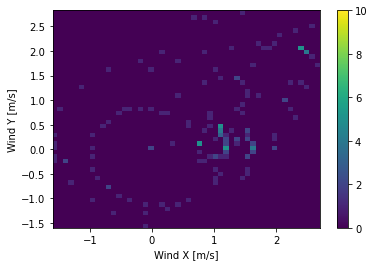

In [39]:
plt.hist2d(kafka_interpo['max Wx'], kafka_interpo['max Wy'], bins=(50, 50), vmax=10)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [34]:
# calculate time of day signal from time index
kafka_interpo.tod_signal(kafka_interpo.index.get_level_values('measuredTime'))

Text(0.5, 1.0, 'Time of day signal')

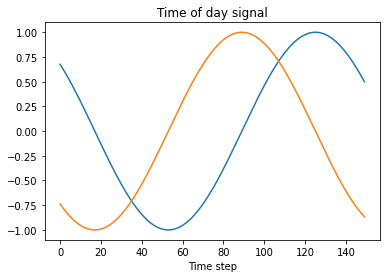

In [35]:
plt.plot(np.array(kafka_interpo['Day sin'])[:25*6])
plt.plot(np.array(kafka_interpo['Day cos'])[:25*6])
plt.xlabel('Time step')
plt.title('Time of day signal')

In [36]:
kafka_interpo.head(2)

measurements.19  measurements.21  \
roadStationId measuredTime                                            
2052          2021-02-09 11:10:00      1021.000000        77.000000   
              2021-02-09 11:20:00      1020.933333        76.333333   

                                   measurements.1        Wx        Wy  \
roadStationId measuredTime                                              
2052          2021-02-09 11:10:00            -4.4  1.260817  0.985058   
              2021-02-09 11:20:00            -4.2  1.145165  0.916356   

                                     max Wx    max Wy   Day sin   Day cos  \
roadStationId measuredTime                                                  
2052          2021-02-09 11:10:00  2.521634  1.970117  0.675590 -0.737277   
              2021-02-09 11:20:00  2.498541  1.999323  0.642788 -0.766044   

                                   Year sin  Year cos  
roadStationId measuredTime                             
2052          2021-02-09 11:10:00  0.635271  0.772289  
              2021-02-09 11:20:00  0.635363  0.772213

In [42]:
# Training set from history file
df = pd.read_csv('vantaa-2017-2020.csv.gz', compression='gzip')
df['time'] = pd.to_datetime(df[['Pv','Kk','Vuosi', 'Klo']]
                   .astype(str).apply(' '.join, 1), format='%d %m %Y %H:%M')
df.drop(columns=['Pv','Kk','Vuosi', 'Klo', 'Aikavyöhyke'], inplace=True)
df.index = df['time']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213965 entries, 2017-01-01 00:00:00 to 2021-02-09 00:00:00
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Ilmanpaine (msl) (hPa)    212924 non-null  float64       
 1   Suhteellinen kosteus (%)  212917 non-null  float64       
 2   Ilman lämpötila (degC)    212913 non-null  float64       
 3   Tuulen suunta (deg)       212272 non-null  float64       
 4   Puuskanopeus (m/s)        212264 non-null  float64       
 5   Tuulen nopeus (m/s)       212248 non-null  float64       
 6   time                      213965 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.1 MB


In [43]:
interpo = df.resample('600s').mean().interpolate()
#interpo = interpo[5::6]
interpo.head(2)

,Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Ilman lämpötila (degC),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
time,,,,,,
2017-01-01 00:00:00,998.1,87.0,3.3,277.0,8.3,6.2
2017-01-01 00:10:00,998.2,87.0,3.1,273.0,7.4,5.3


In [44]:
wind_direction = interpo['Tuulen suunta (deg)']
wind_v = interpo['Tuulen nopeus (m/s)']
wind_v_max = interpo['Puuskanopeus (m/s)']

Text(0, 0.5, 'Wind Velocity [m/s]')

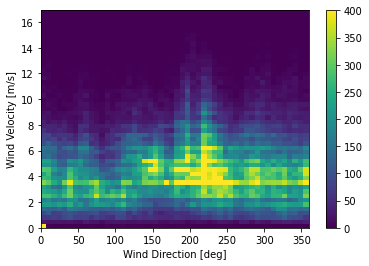

In [45]:
plt.hist2d(wind_direction, wind_v, bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [46]:
# Convert to wind vector
interpo.wind_vector(interpo.pop('Tuulen nopeus (m/s)'), interpo.pop('Puuskanopeus (m/s)'), interpo.pop('Tuulen suunta (deg)'))


(-16.07285512538809, 13.3882665834825, -14.030928932907388, 12.718853254308373)

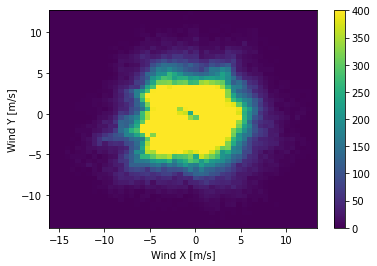

In [47]:
plt.hist2d(interpo['Wx'], interpo['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

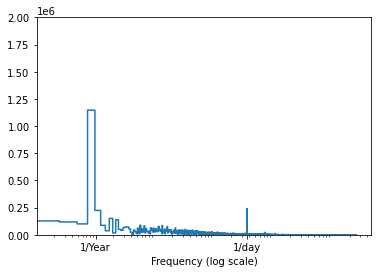

In [48]:
# look for seasonality although we know that year and day will be important features for weather data
fft = tf.signal.rfft(interpo['Ilman lämpötila (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(interpo['Ilman lämpötila (degC)'])
samples_per_year = 6*24*365.2524 # 10m sampling rate
years_per_dataset = n_samples_h/(samples_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [49]:
# calculate time of day signal from time index
interpo.tod_signal(interpo.index.get_level_values('time'))

Text(0.5, 1.0, 'Time of day signal')

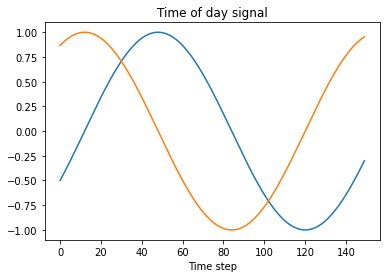

In [50]:
plt.plot(np.array(interpo['Day sin'])[:25*6])
plt.plot(np.array(interpo['Day cos'])[:25*6])
plt.xlabel('Time step')
plt.title('Time of day signal')

In [66]:
# Split dataset
column_indices = {name: i for i, name in enumerate(interpo.columns)}

n = len(interpo)
train_df = interpo[0:int(n*0.7)]
val_df = interpo[int(n*0.7):int(n*0.9)]
test_df = interpo[int(n*0.9):]

num_features = interpo.shape[1]

In [67]:
# Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [68]:
train_df.head(2)


,Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Ilman lämpötila (degC),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,,
2017-01-01 00:00:00,-1.246447,0.368398,-0.375844,0.316059,-1.665835,0.301527,-1.571848,-0.707104,1.224741,-0.010058,1.493411
2017-01-01 00:10:00,-1.237814,0.368398,-0.397383,0.181052,-1.406832,0.176988,-1.390923,-0.653009,1.254419,-0.009891,1.493410


In [69]:
foo = train_std * train_df + train_mean
foo.head(2)

,Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Ilman lämpötila (degC),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,,
2017-01-01 00:00:00,998.1,87.0,3.3,0.755590,-6.153786,1.011516,-8.238133,-0.500000,0.866025,0.008931,0.999960
2017-01-01 00:10:00,998.2,87.0,3.1,0.277381,-5.292737,0.387286,-7.389859,-0.461749,0.887011,0.009050,0.999959


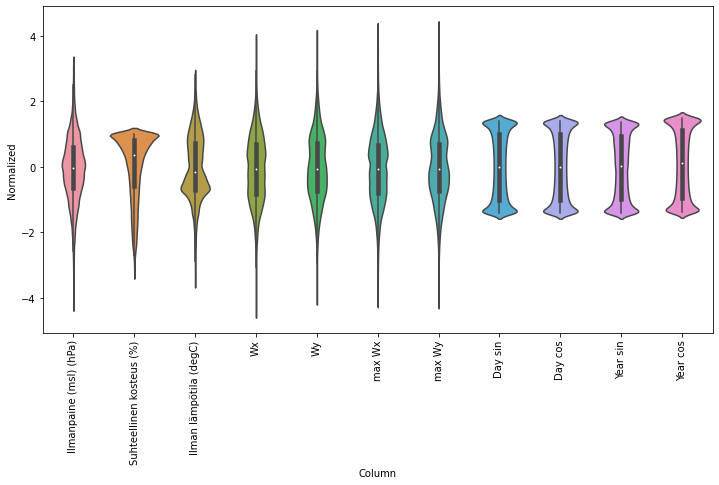

In [70]:
df_std = (interpo - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(interpo.keys(), rotation=90)

In [71]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [72]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [73]:
def plot(self, model=None, plot_col='Ilman lämpötila (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time steps')

WindowGenerator.plot = plot

In [59]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [60]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [61]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [62]:
# Now that we have defined the functions let's try multi step models to predict next 24h using on 24h history
val_performance = {}
performance = {}

Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label indices: [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238

Total window size: 288
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143]
Label indices: [144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

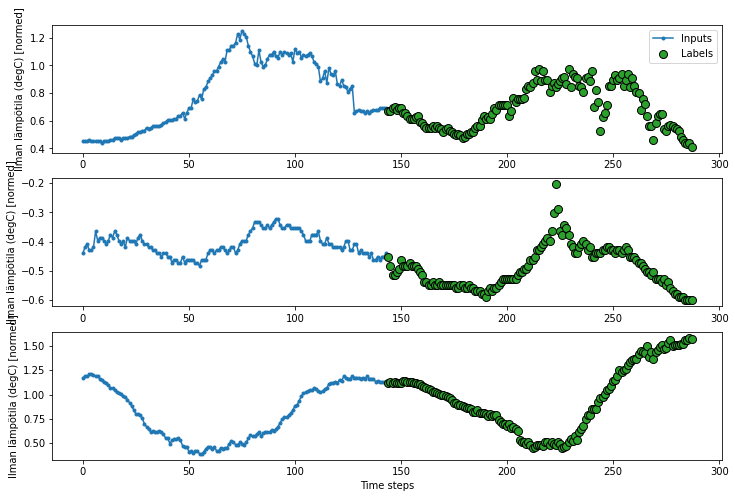

In [63]:
OUT_STEPS = 6*24
multi_window = WindowGenerator(input_width=6*24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1342/1342 [==============================] - 14s 11ms/step - loss: 0.7927 - mean_absolute_error: 0.5724


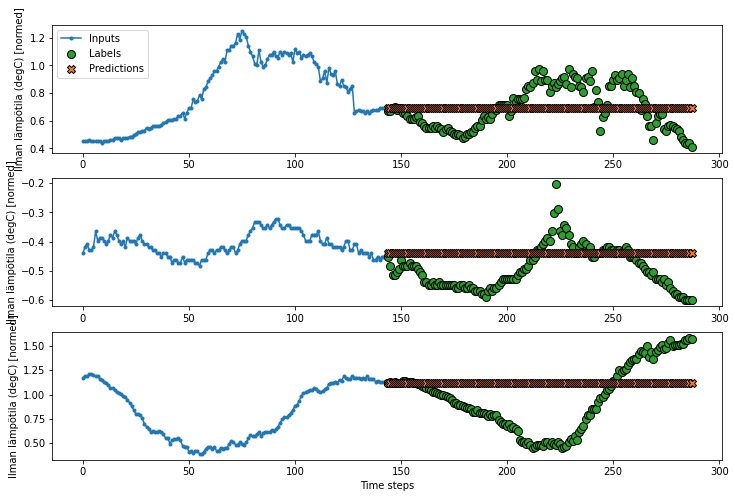

In [64]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1342/1342 [==============================] - 15s 11ms/step - loss: 0.5998 - mean_absolute_error: 0.4434


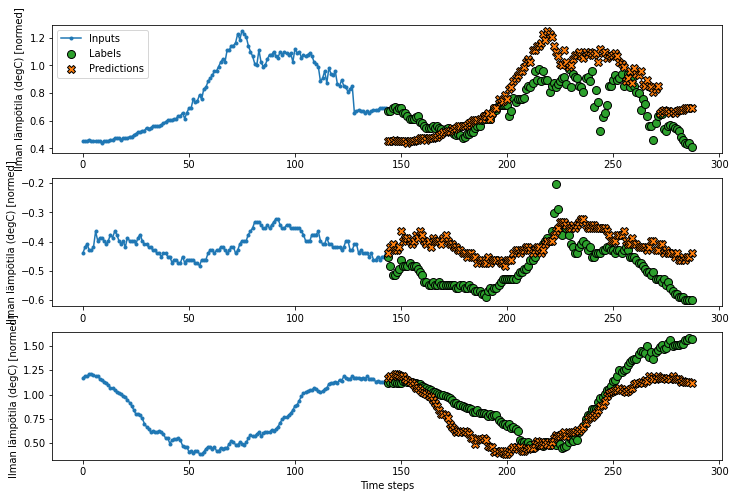

In [75]:
# this baseline repeats the previous day assuming tomorrow is same as today
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [80]:
repeat_baseline.predict(kafka_interpo)

array([[ 1.02100000e+03,  7.70000000e+01, -4.40000010e+00, ...,
        -7.37277329e-01,  6.35271132e-01,  7.72289157e-01],
       [ 1.02093335e+03,  7.63333359e+01, -4.19999981e+00, ...,
        -7.66044438e-01,  6.35363400e-01,  7.72213280e-01],
       [ 1.02086664e+03,  7.56666641e+01, -4.00000000e+00, ...,
        -7.93353319e-01,  6.35455668e-01,  7.72137344e-01],
       ...,
       [ 1.02070001e+03,  8.90000000e+01, -6.30000019e+00, ...,
        -1.00000000e+00,  6.50006652e-01,  7.59928465e-01],
       [ 1.02070001e+03,  9.00000000e+01, -6.40000010e+00, ...,
        -9.99048233e-01,  6.50097489e-01,  7.59850860e-01],
       [ 1.02079999e+03,  9.10000000e+01, -6.40000010e+00, ...,
        -9.96194720e-01,  6.50188208e-01,  7.59773195e-01]], dtype=float32)

In [77]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
4717/4717 [==============================] - 49s 10ms/step - loss: 0.3983 - mean_absolute_error: 0.4505 - val_loss: 0.2959 - val_mean_absolute_error: 0.3114
Epoch 2/20
 968/4717 [=====>........................] - ETA: 32s - loss: 0.2598 - mean_absolute_error: 0.2944

KeyboardInterrupt: 

NameError: name 'multi_linear_model' is not defined

1342/1342 [==============================] - 29s 21ms/step - loss: 0.3530 - mean_absolute_error: 0.3454


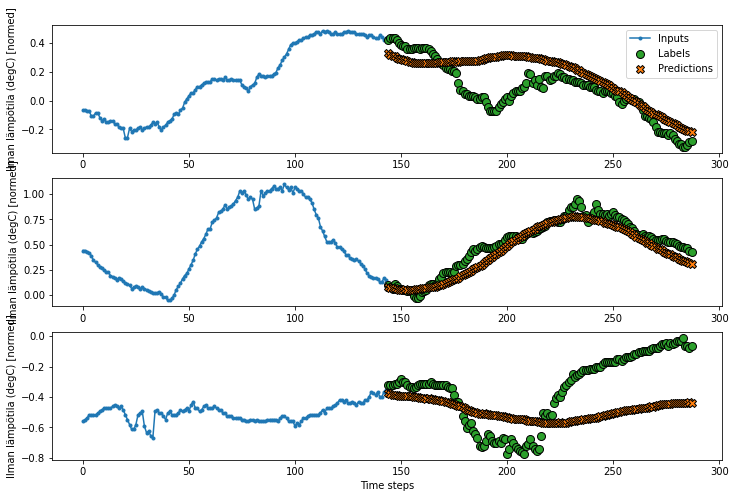

In [37]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [74]:
multi_lstm_model.predict(kafka_interpo)

NameError: name 'multi_lstm_model' is not defined

In [172]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [173]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [174]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [175]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 11])

In [176]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

224/224 [==============================] - 1s 3ms/step - loss: 0.3187 - mean_absolute_error: 0.3497


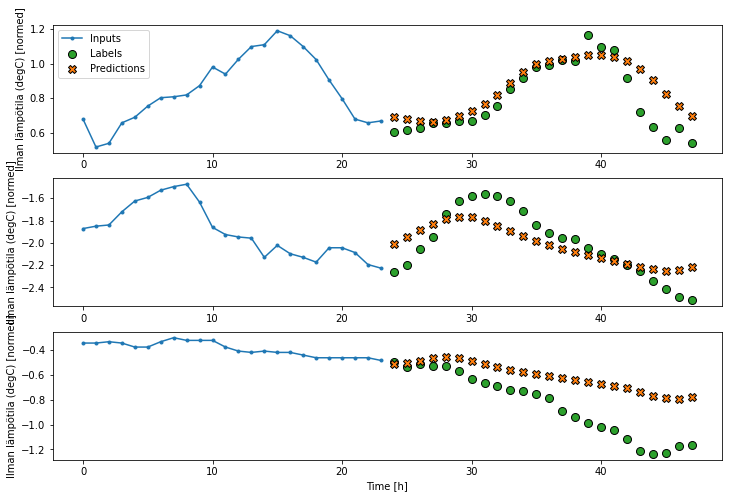

In [177]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

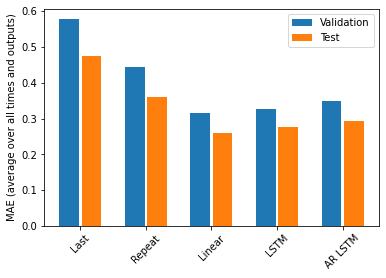

In [178]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()